In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import os
import random
from scipy.ndimage import zoom
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
register_matplotlib_converters()


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

In [2]:
# tf.compat.v1.enable_eager_execution()
# print("Eager execution: {}".format(tf.compat.v1.executing_eagerly()))

In [3]:
### READ DATA ###

df = pd.read_csv('BeijingPM2.csv')
df['date'] = pd.to_datetime(df[['year','month','day','hour']])
df['cbwd'] = df.cbwd.factorize()[0]
df['pm2.5'] = df['pm2.5'].interpolate(method='linear', limit_direction='both')

print(df.shape)
df.head()

(43824, 14)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,0,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,0,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,0,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,0,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,0,12.97,0,0,2010-01-01 04:00:00


In [4]:
df.isna().sum()/len(df)

No       0.0
year     0.0
month    0.0
day      0.0
hour     0.0
pm2.5    0.0
DEWP     0.0
TEMP     0.0
PRES     0.0
cbwd     0.0
Iws      0.0
Is       0.0
Ir       0.0
date     0.0
dtype: float64

In [5]:
### TRAIN, VALIDATION, TEST TEMPORAL SPLIT ###

columns = ['DEWP','TEMP','PRES','Iws','Is','Ir','cbwd']

y_train = df[df.year <= 2012]['pm2.5'].copy().values
train_date = df[df.year <= 2012].date.values
x_train = df[df.year <= 2012][columns].copy()

y_val = df[df.year == 2013]['pm2.5'].copy().values
val_date = df[df.year == 2013].date.values
x_val = df[df.year == 2013][columns].copy()

y_test = df[df.year == 2014]['pm2.5'].copy().values
test_date = df[df.year == 2014].date.values
x_test = df[df.year == 2014][columns].copy()

print(x_train.shape, x_val.shape, x_test.shape)

(26304, 7) (8760, 7) (8760, 7)


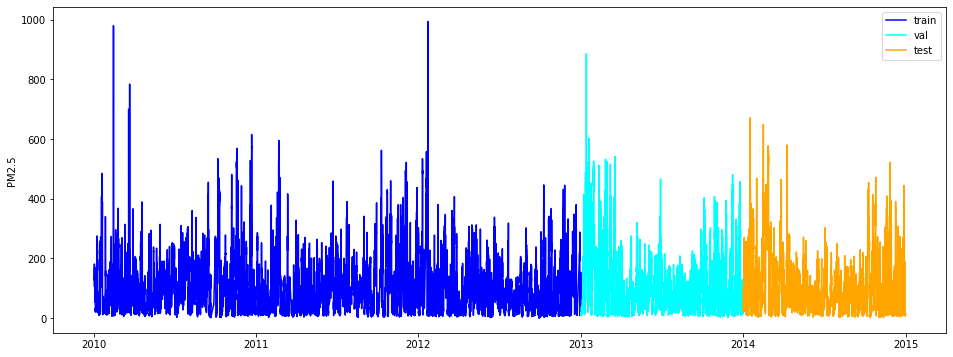

In [6]:
### PLOT TRAIN, VALIDATION, TEST ###

plt.figure(figsize=(16,6))

plt.plot(train_date, y_train, label='train', c='blue')
plt.plot(val_date, y_val, label='val', c='cyan')
plt.plot(test_date, y_test, label='test', c='orange')
plt.ylabel('PM2.5')
plt.legend()

In [7]:
### UTILITY FUNCTION FOR SEQUENCES GENERATION ###

sequence_length = 30

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [8]:
### GENERATE SEQUENCES ###

X_train, X_val, X_test = [], [], []

for sequence in gen_sequence(x_train, sequence_length, columns):
    X_train.append(sequence)
    
for sequence in gen_sequence(x_val, sequence_length, columns):
    X_val.append(sequence)
    
for sequence in gen_sequence(x_test, sequence_length, columns):
    X_test.append(sequence)
    
X_train, X_val, X_test = np.asarray(X_train), np.asarray(X_val), np.asarray(X_test)
print(X_train.shape, X_val.shape, X_test.shape)

(26274, 30, 7) (8730, 30, 7) (8730, 30, 7)


In [9]:
### UTILITY FUNCTIONS FOR TARGET SCALING ###

def scale_target(y, mean, std):
    return (y - mean)/std

def reverse_target(pred, mean, std): 
    return pred*std + mean

In [10]:
### SCALE TARGET ###

mean_train = y_train.mean()
std_train = y_train.std()

y_train_seq = scale_target(y_train[sequence_length:], mean_train, std_train)
y_val_seq = scale_target(y_val[sequence_length:], mean_train, std_train)
y_test_seq = scale_target(y_test[sequence_length:], mean_train, std_train)

print(y_train_seq.shape, y_val_seq.shape, y_test_seq.shape)

(26274,) (8730,) (8730,)


In [11]:
### SCALE SEQUENCES ###

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,len(columns))).reshape(X_train.shape).astype('float32')
X_val = scaler.transform(X_val.reshape(-1,len(columns))).reshape(X_val.shape).astype('float32')
X_test = scaler.transform(X_test.reshape(-1,len(columns))).reshape(X_test.shape).astype('float32')

In [12]:
### DEFINE MODEL ###

def get_model():
    
    opt = Adam(lr=0.001)
    
    inp_seq = Input(shape=(sequence_length,len(columns)))
    
    x = Bidirectional(GRU(32, return_sequences=True))(inp_seq)
    x = AveragePooling1D(2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same', 
               name='extractor')(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(1)(x)
    
    model = Model(inp_seq, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model

In [13]:
model = get_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 7)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 64)            7872      
_________________________________________________________________
average_pooling1d (AveragePo (None, 15, 64)            0         
_________________________________________________________________
extractor (Conv1D)           (None, 15, 32)            6176      
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                7696      
_________________________________________________________________
dropout (Dropout)            (None, 16)               

In [14]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model = get_model()
model.fit([X_train], y_train_seq, epochs=100, batch_size=512, verbose=1, callbacks=[es], 
          validation_data=([X_val], y_val_seq))

Epoch 1/100
52/52 [==============================] - 5s 101ms/step - loss: 0.7401 - val_loss: 0.7039
Epoch 2/100
52/52 [==============================] - 3s 66ms/step - loss: 0.5896 - val_loss: 0.6571
Epoch 3/100
52/52 [==============================] - 3s 61ms/step - loss: 0.5590 - val_loss: 0.6583
Epoch 4/100
52/52 [==============================] - 4s 73ms/step - loss: 0.5412 - val_loss: 0.6086
Epoch 5/100
52/52 [==============================] - 4s 75ms/step - loss: 0.5263 - val_loss: 0.6327
Epoch 6/100
52/52 [==============================] - 3s 63ms/step - loss: 0.5134 - val_loss: 0.6807
Epoch 7/100
52/52 [==============================] - 3s 67ms/step - loss: 0.5029 - val_loss: 0.6180
Epoch 8/100
52/52 [==============================] - 4s 69ms/step - loss: 0.4991 - val_loss: 0.5987
Epoch 9/100
52/52 [==============================] - 3s 63ms/step - loss: 0.4826 - val_loss: 0.6554
Epoch 10/100
52/52 [==============================] - 4s 75ms/step - loss: 0.4804 - val_loss: 0.602

In [15]:
### MAKE PREDICTION ON TEST ###

pred = reverse_target(model.predict([X_test]).ravel(), mean_train, std_train)

print(mean_absolute_error(y_test[sequence_length:], pred))

44.681193800289336


Text(0, 0.5, 'PM2.5')

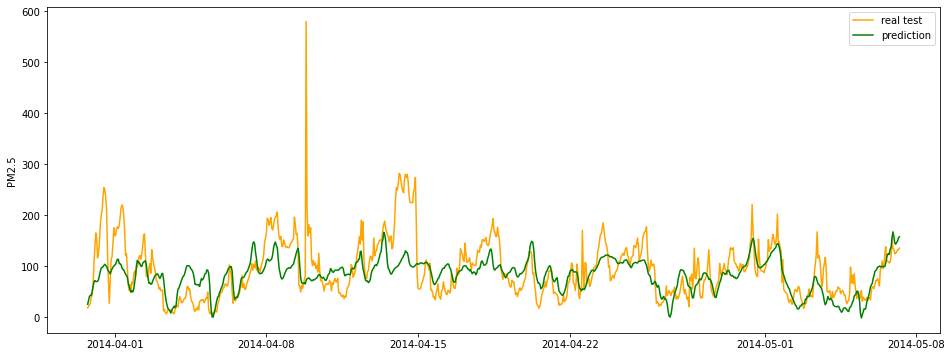

In [16]:
### PREDICTIONS vs REALITY ON TEST ###

plt.figure(figsize=(16,6))

start, end = 2100, 3000
plt.plot(test_date[sequence_length+start:end+sequence_length], y_test[sequence_length+start:end+sequence_length], c='orange', label='real test')
plt.plot(test_date[sequence_length+start:end+sequence_length], pred[start:end], c='green', label='prediction')
plt.legend(); plt.ylabel('PM2.5')

# INFERENCE ON PREDICTIONS

In [17]:
### UTILITY FUNCTIONS FOR GRADIENT IMPORTANCE AND ACTIVIATION MAPS GENERATION ### 


def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

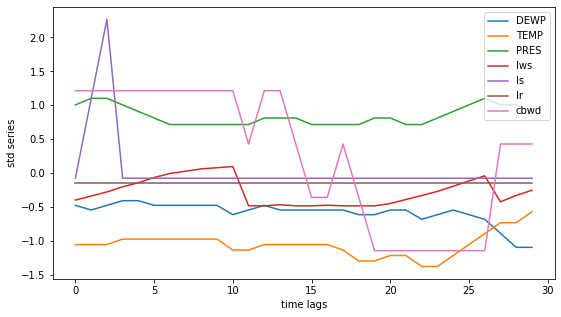

In [18]:
### DISPLAY INPUT SEQUENCE ###

id_ = 128

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
plt.ylabel('std series'); plt.xlabel('time lags'); plt.legend(columns)

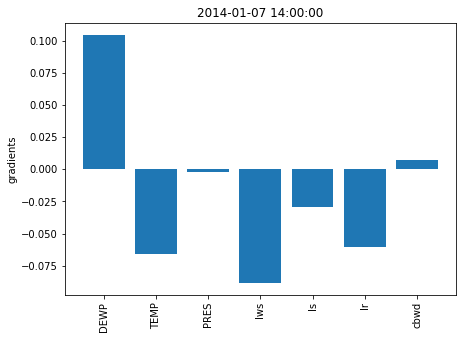

In [19]:
### GRADIENTS IMPORTANCE ###

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(7,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

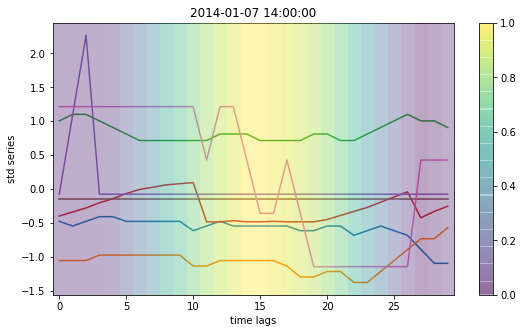

In [20]:
### GENERATE ACTIVATION ON INPUT SEQUENCE ###

activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
plt.ylabel('std series'); plt.xlabel('time lags'); plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)